<a href="https://colab.research.google.com/github/varvelac/medical-callback-data-analytics/blob/main/medical_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [42]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#sns.set_theme(style="whitegrid")
# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
# sns.set_palette(sns.xkcd_palette(colors))
from datetime import datetime, timedelta


#using google spreadsheets so i don't have to keep uploading my files
from google.colab import drive
drive.mount('/content/gdrive')
!pip install gspread gspread_dataframe
import gspread
from gspread_dataframe import set_with_dataframe





Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/<target_spreadsheet_id>')
worksheet = sh.sheet1

# Read the source Google Sheets
spreadsheet_ids = ['<spreadsheet_id_1>', '<spreadsheet_id_2>', ...]

df_list = []
for spreadsheet_id in spreadsheet_ids:
  sh = gc.open_by_url(f'https://docs.google.com/spreadsheets/d/{spreadsheet_id}')
  worksheet = sh.sheet1
  df_list.append(worksheet.get_as_dataframe())

# Append the source Google Sheets into a single DataFrame
df = pd.concat(df_list)

# Write the DataFrame to the target Google Sheet
set_with_dataframe(worksheet, df)

In [4]:
df = pd.read_csv('/content/aug-1-2022-jan-25-2023.csv')
df.head()

,ID,Date of Birth,Test Type,Referral Date,Ordering Last Name,Ordering First,Test Date,Test Status,IV Status,Location Name,Unable to Schedule?,Unable to Schedule Reason,Incomplete Referral?,Missing Information:,Primary Insurance
0,450980|450975,06/17/1992,HST,01/25/2023,Zouein,Elie,NaN,To Be Scheduled,Pending- NEW Referral,CA_SM_Santa_Barbara,No,NaN,Pending - Needs Review,,Patient Pay
1,450977|419459,04/26/1961,CPAP,01/25/2023,Dalla Tor,Nelson,NaN,To Be Scheduled,Pending- NEW Referral,CA_SM_Cypress,No,NaN,Pending - Needs Review,,Alignment and Pioneer Provider Network
2,450963|450959,05/16/1989,Split,01/25/2023,Patel,Ashish B.,NaN,To Be Scheduled,Pending- NEW Referral,CA_SM_Pasadena,No,NaN,Pending - Needs Review,,CIGNA - SLEEP
3,450908|450902,03/05/2005,PAP-NAP,01/25/2023,Adan,Olga,NaN,To Be Scheduled,Pending- NEW Referral,CA_SM_Redlands,No,NaN,Incomplete Referral,Clinical Notes|||Signed Order|||Study Type,CIGNA - SLEEP
4,450865|450853,12/10/1941,HST,01/25/2023,Lerner,David,NaN,To Be Scheduled,Pending- NEW Referral,CA_SM_Santa_Barbara,No,NaN,Pending - Needs Review,,Medicare California - Southern


Let's seperate the dob and referral date into a date dataframe.
Let's seperate out some category columns that we will convert to numeric for ml training

In [5]:
#not dropping the columns.  seperating to recombine
#df.drop(columns=['ID', 'Date of Birth', 'Referral Date', 'Ordering Last Name', 'Ordering First', 'Missing Information:', 'Unable to Schedule Reason ', 'Primary Insurance', 'Test Date'], axis=1, inplace=True)
df_numeric = df.loc[:, ['ID','Test Type', 'Test Status', 'IV Status', 'Location Name', 'Unable to Schedule?','Incomplete Referral?', 'Unable to Schedule Reason ']]
df_dates = df.loc[:, ['ID','Date of Birth', 'Referral Date']]
df_numeric_w_categories = df.loc[:, ['ID','Test Type', 'Test Status', 'IV Status', 'Location Name', 'Unable to Schedule?','Incomplete Referral?', 'Unable to Schedule Reason ']]

In [6]:
#leaving here for reference
# print(pd.factorize(df_train['Test Status']))
# df_train["Test Status"] = pd.factorize(df_train["Test Status"])[0]
print(df_numeric["IV Status"].value_counts().sort_index())


df_numeric['IV Status_numeric'], mapping = pd.factorize(df_numeric["IV Status"])

# Save the mapping between integers and string values as a dictionary
mapping = dict(zip(mapping, range(len(mapping))))

print(mapping)


Complete                            2159
Denied                               114
Pending- Authorization Initiated      26
Pending- Hold IV                       4
Pending- NEW Referral               2329
Pending- Need additional info         90
Name: IV Status, dtype: int64
{'Pending- NEW Referral': 0, 'Complete': 1, 'Pending- Need additional info': 2, 'Pending- Authorization Initiated': 3, 'Denied': 4, 'Pending- Hold IV': 5}


Lets convert the dob column to age.

In [7]:
# Convert DOB column to datetime then to age
df_dates.dropna(subset=['Date of Birth', 'Referral Date'], inplace=True)
#df_dates = df_dates[df_dates['Date of Birth', 'Referral Date'] != 'Invalid']
df_dates['Referral Date'] = pd.to_datetime(df_dates['Referral Date'])
df_dates["Age"] = round((pd.datetime.now() - pd.to_datetime(df_dates["Date of Birth"])).dt.days/365)

df_dates['Referral Month'] = df_dates['Referral Date'].dt.month


df_dates.drop(columns=['Date of Birth'], axis=1, inplace=True)
df_dates.drop(columns=['Referral Date'], axis=1, inplace=True)
#the ID is messy, we just need to give it cleaner but just as arbitrary values
encoder = LabelEncoder()
df_dates['ID'] = encoder.fit_transform(df_dates['ID'])
df_dates.head()



,ID,Age,Referral Month
0,4723,31.0,1
1,4722,62.0,1
2,4721,34.0,1
3,4720,18.0,1
4,4719,81.0,1


In [8]:

mapping_defs = {}
#save scumming

for column in df_numeric.columns:
    df_numeric[column], uniques = pd.factorize(df_numeric[column])
    mapping_defs[column] = dict(zip(uniques, range(len(uniques))))

df_numeric.head()



,ID,Test Type,Test Status,IV Status,Location Name,Unable to Schedule?,Incomplete Referral?,Unable to Schedule Reason,IV Status_numeric
0,0,0,0,0,0,0,0,-1,0
1,1,1,0,0,1,0,0,-1,0
2,2,2,0,0,2,0,0,-1,0
3,3,3,0,0,3,0,1,-1,0
4,4,0,0,0,0,0,0,-1,0


In [9]:
print(mapping_defs['IV Status'])

{'Pending- NEW Referral': 0, 'Complete': 1, 'Pending- Need additional info': 2, 'Pending- Authorization Initiated': 3, 'Denied': 4, 'Pending- Hold IV': 5}


Let's join the dataframes on ID.

In [10]:
#print(df_numeric.apply(type))
#print(df_dates.apply(type))
df_dates['ID'] = df_dates['ID'].astype(int)
df_numeric['ID'] = df_numeric['ID'].astype(int)

merged_df = pd.merge(df_numeric, df_dates, on='ID')
merged_df.head()


,ID,Test Type,Test Status,IV Status,Location Name,Unable to Schedule?,Incomplete Referral?,Unable to Schedule Reason,IV Status_numeric,Age,Referral Month
0,0,0,0,0,0,0,0,-1,0,42.0,10
1,1,1,0,0,1,0,0,-1,0,67.0,10
2,2,2,0,0,2,0,0,-1,0,54.0,11
3,3,3,0,0,3,0,1,-1,0,45.0,8
4,4,0,0,0,0,0,0,-1,0,30.0,8


# Questions to answer
- volume by test type

1.   what % of total orders were completed 
2.   of the order that were not completed due to unable to schedule - reason: unable to contact pt
3. same but reason: patient refused
4. highest volume ordering doctors (not interpreting doctor)
5. highest volume by primary insurance

In [41]:
#Basic Filter
def filter_df(df, column, value):
    return df[df[column] == value]

def multi_filter_df(df, columns, values):
    result = df
    for col, val in zip(columns, values):
        result = result[result[col] == val]
    return result

no_contact_no_schedule = multi_filter_df(df_numeric_w_categories, ['Unable to Schedule?', 'Unable to Schedule Reason '], ['No', 'PATIENT: Unable to contact'] )
refuse_no_schedule = multi_filter_df(df_numeric_w_categories, ['Unable to Schedule?', 'Unable to Schedule Reason '], ['No', 'PATIENT: Refused study'])

no_contact_num  = filter_df(df_numeric_w_categories, 'Unable to Schedule?','No').shape[0]


percent_no_contact = (no_contact_no_schedule.shape[0] /no_contact_num  ) * 100
percent_refuse = (refuse_no_schedule.shape[0] / no_contact_num) * 100
print('% of patients that weren\'t scheduled for reason: Unable to contact: {:.2f}%'.format(percent_no_contact))
print('% of patients that weren\'t scheduled for reason: Pateient refused: {:.2f}%'.format(percent_refuse))


% of patients that weren't scheduled for reason: Unable to contact: 7.94%
% of patients that weren't scheduled for reason: Pateient refused: 0.34%


2. What percentage of orders were not completed due to the reason "unable to contact patient"? - 7.94%
3. What percentage of orders were not completed due to the reason "pateient refused"? - 0.34%

[2393, 534, 21, 1734, 40, 1, 1]


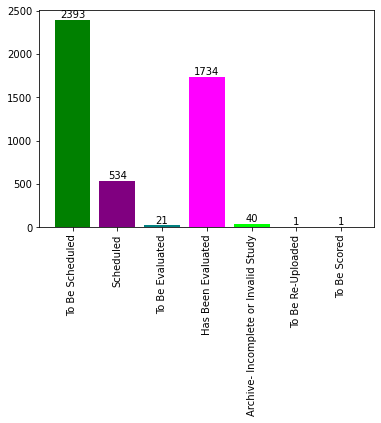

In [14]:
#print(np.array(unique_maps['IV Status']))
distArrayVar = list(merged_df['Test Status'].value_counts().sort_index().values)
print(distArrayVar)

#print(distArrayVar)
height = distArrayVar
bars = list(mapping_defs['Test Status'].keys())
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['green', 'purple', 'teal', 'magenta', 'lime', 'purple', 'black'])
for i, v in enumerate(height):
    plt.text(x_pos[i]+0.0, v+0.01, str(v), ha = 'center', va = 'bottom')
# Create names on the x-axis
plt.xticks(x_pos, bars, rotation=90)



# Show graph
plt.show()
#

['To Be Scheduled', 'Scheduled', 'To Be Evaluated', 'Has Been Evaluated', 'Archive- Incomplete or Invalid Study', 'To Be Re-Uploaded', 'To Be Scored']


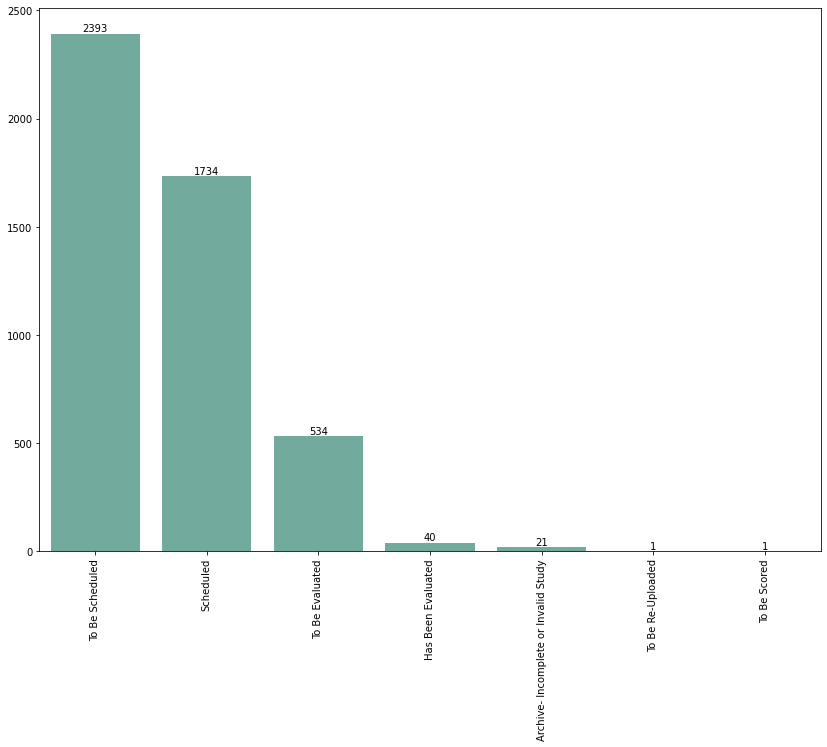

In [18]:
plt.figure(figsize=(14, 10))
print(list(mapping_defs['Test Status'].keys()))
# Make a barplot
y = list(df_numeric_w_categories['Test Status'].value_counts().values)
x = list(mapping_defs['Test Status'].keys())
sns.barplot(
    x = x, 
    y = y, 
    data=merged_df, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);

x_pos = np.arange(len(y))

for i, v in enumerate(y):
    plt.text(x_pos[i]+0.0, v+0.01, str(v), ha = 'center', va = 'bottom')
plt.xticks(x_pos, x, rotation=90)
plt.show()

Pending- NEW Referral         :      2329<br>
Complete                      :      2159<br>
Denied                        :       114<br>
Pending- Need additional info :        90<br>
Pending- Authorization Initiated  :    26<br>
Pending- Hold IV                :       4<br>



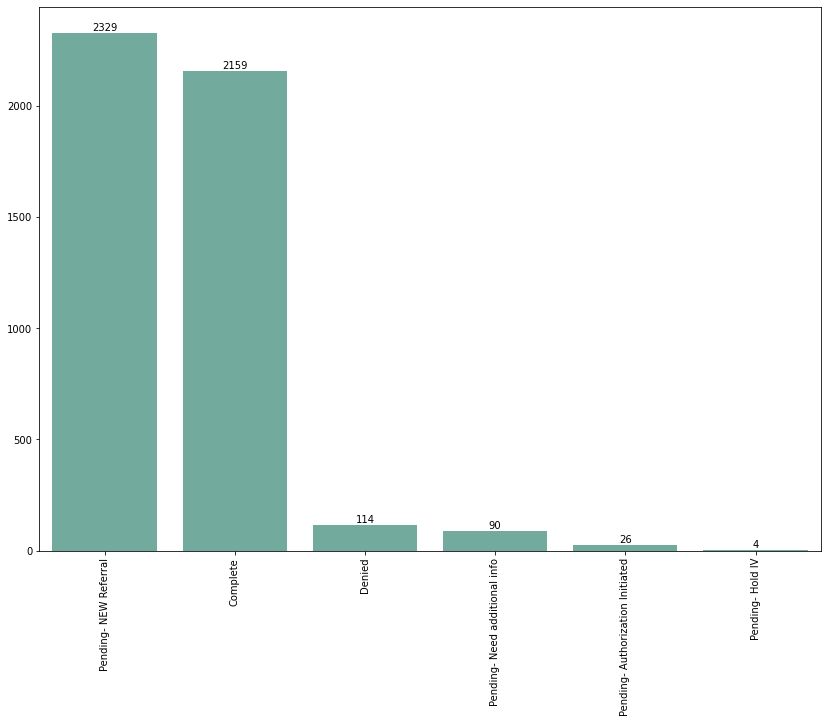

In [19]:

plt.figure(figsize=(14, 10))

# Make a barplot
y = list(df_numeric_w_categories['IV Status'].value_counts().values)
x = list(df_numeric_w_categories['IV Status'].value_counts().index)
sns.barplot(
    x=x, 
    y=y, 
    data=merged_df, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2'
);

x_pos = np.arange(len(y))

for i, v in enumerate(y):
    plt.text(x_pos[i]+0.0, v+0.01, str(v), ha = 'center', va = 'bottom')
plt.xticks(x_pos, x, rotation=90)
plt.show()

def right_mapper(){}

-1       2
 0    2329
 1    2159
 2      90
 3      26
 4     114
 5       4
Name: IV Status, dtype: int64
['Pending- NEW Referral', 'Complete', 'Pending- Need additional info', 'Pending- Authorization Initiated', 'Denied', 'Pending- Hold IV']


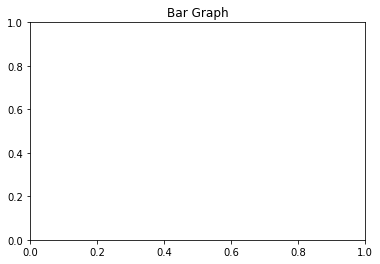

In [20]:
# Load some data
# data = ...
print(merged_df['IV Status'].value_counts().sort_index())



x_variable = list(mapping_defs['IV Status'].keys())
y_variable = merged_df['IV Status']
data = merged_df['IV Status']

print(x_variable)
# Plot a bar graph using the data
#sns.barplot(x=x_variable, y=y_variable, data=data)

# Add a title to the plot
plt.title('Bar Graph')

# Show the plot
plt.show()

here's another single column visualization.

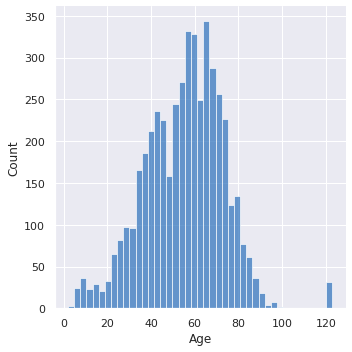

In [ ]:
sns.displot(merged_df['Age'])

In [ ]:
print("Skewness: %f" % merged_df['Test Type'].skew())
print("Kurtosis: %f" % merged_df['Test Type'].kurt())

Skewness: 0.385246
Kurtosis: -1.479339


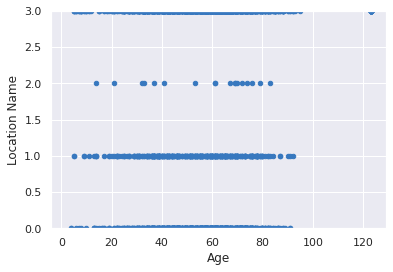

In [ ]:
varX = 'Age'
varY = 'Location Name'
data = pd.concat([merged_df[varY], merged_df[varX]], axis=1)
data.plot.scatter(x=varX, y=varY, ylim=(0,3));

This is just a duplicate of the above

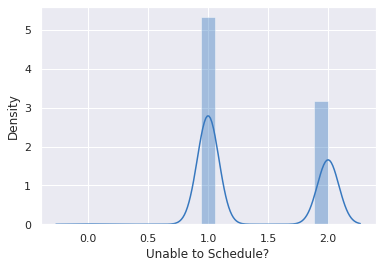

In [ ]:
sns.distplot(df_numeric['Unable to Schedule?']);

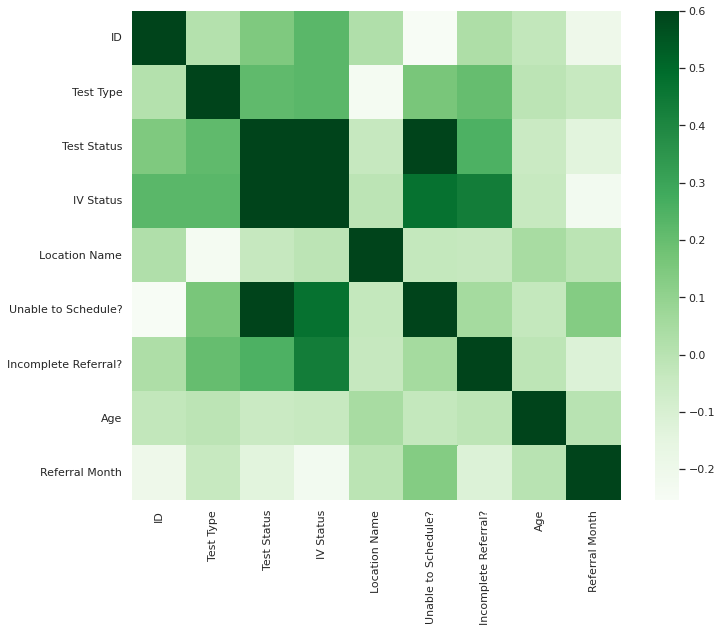

In [ ]:
corrmat = merged_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.6,cmap="Greens", square=True);